### Load Modules

In [1]:
from __future__ import absolute_import, division, print_function

import dolfin as dl
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

In [2]:
def true_model(prior):
    noise = dl.Vector()
    prior.init_vector(noise,"noise")
    parRandom.normal(1., noise)
    mtrue = dl.Vector()
    prior.init_vector(mtrue, 0)
    prior.sample(noise,mtrue)
    return mtrue

In [3]:
ndim = 2
nx = 32
ny = 32
mesh = dl.UnitSquareMesh(nx, ny)
Vh2 = dl.FunctionSpace(mesh, 'Lagrange', 2)
Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vh = [Vh2, Vh1, Vh2]
print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(
    Vh[STATE].dim(), Vh[PARAMETER].dim(), Vh[ADJOINT].dim()) )

Number of dofs: STATE=4225, PARAMETER=1089, ADJOINT=4225


In [4]:
def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)
    
def pde_varf(u,m,p):
    return dl.exp(m)*dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx - f*p*dl.dx
    
pde = PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

Prior regularization: (delta_x - gamma*Laplacian)^order: delta=0.5, gamma=0.1, order=2


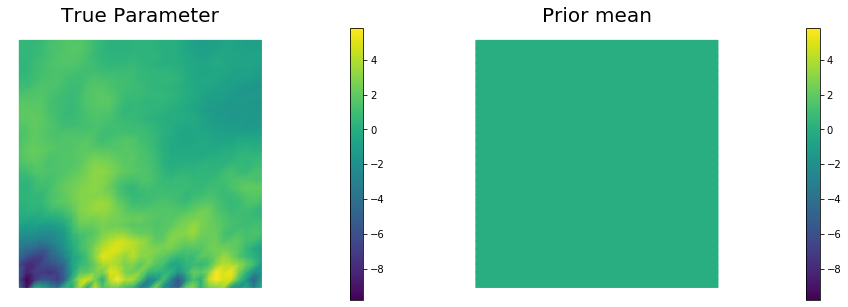

In [5]:
gamma = .1
delta = .5
    
anis_diff = dl.Expression("x[1]", degree=1)
anis_diff.theta0 = 2.
anis_diff.theta1 = .5
anis_diff.alpha = math.pi/4 
prior = BiLaplacianPrior(Vh[PARAMETER], gamma, delta, anis_diff, robin_bc=True)
print("Prior regularization: (delta_x - gamma*Laplacian)^order: delta={0}, gamma={1}, order={2}".format(delta, gamma,2))    


mtrue = true_model(prior)
                   
objs = [dl.Function(Vh[PARAMETER],mtrue), dl.Function(Vh[PARAMETER],prior.mean)]
mytitles = ["True Parameter", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

model = Model(pde,prior, misfit)

Number of observation points: 300


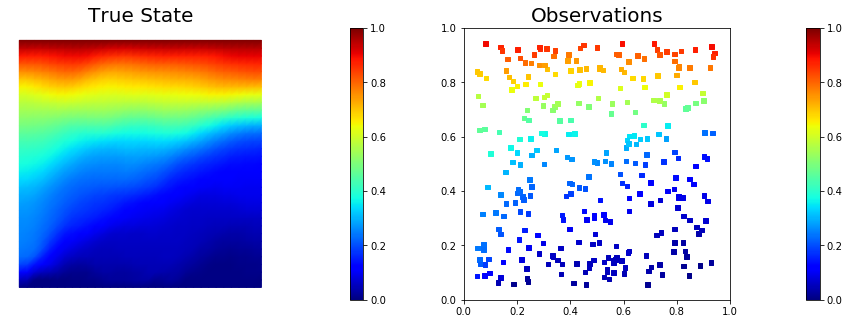

In [7]:
ntargets = 300
rel_noise = 0.005


targets = np.random.uniform(0.05,0.95, [ntargets, ndim] )
print( "Number of observation points: {0}".format(ntargets) )
misfit = PointwiseStateObservation(Vh[STATE], targets)

utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[STATE], x, 1e-9)
misfit.B.mult(x[STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax, cmap="jet")
nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax, cmap="jet")
plt.show()

### Set up the model and test gradient and Hessian

(yy, H xx) - (xx, H yy) =  -1.6548149400645327e-14


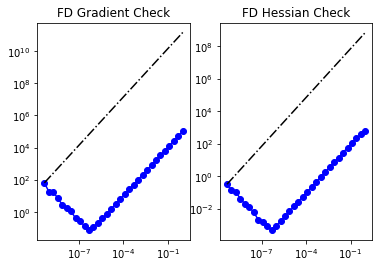

In [8]:
model = Model(pde, prior, misfit)

m0 = dl.interpolate(dl.Expression("sin(x[0])", degree=5), Vh[PARAMETER])
_ = modelVerify(model, m0.vector(), 1e-12)

### Compute the MAP point


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    2.248604e+04    2.248577e+04    2.696523e-01   -4.219461e+05   8.054267e+05   1.000000e+00   5.000000e-01
  2   1    1.494696e+04    1.494653e+04    4.257518e-01   -1.534618e+04   1.395172e+05   1.000000e+00   4.161989e-01
  3   3    4.610132e+03    4.609107e+03    1.025777e+00   -2.066616e+04   5.545090e+04   1.000000e+00   2.623864e-01
  4   2    3.771134e+03    3.770052e+03    1.081949e+00   -1.679758e+03   3.657353e+04   1.000000e+00   2.130936e-01
  5  10    3.548821e+03    3.541021e+03    7.800241e+00   -6.316391e+03   2.266732e+04   1.000000e+00   1.677595e-01
  6   1    1.079240e+03    1.071547e+03    7.692757e+00   -5.455695e+03   7.691905e+04   1.000000e+00   3.090324e-01
  7   2    6.843698e+02    6.766196e+02    7.750274e+00   -7.830172e+02   2.623065e+04   1.000000e+00   1.804644e-01
  8  16    5.292608e+02    5.137646e+02    1.549624e+01   -1.

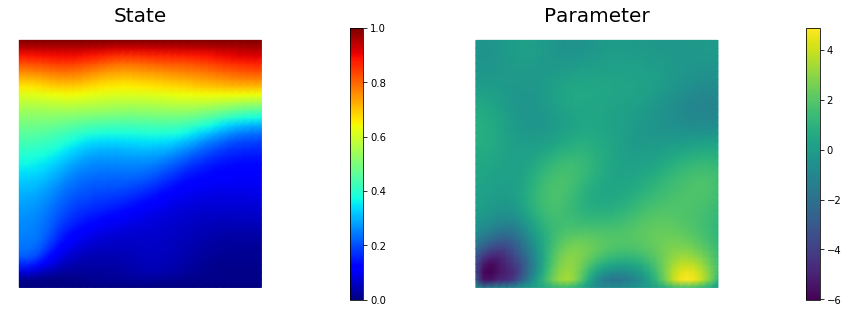

In [9]:
m = prior.mean.copy()
solver = ReducedSpaceNewtonCG(model)
solver.parameters["rel_tolerance"] = 1e-6
solver.parameters["abs_tolerance"] = 1e-12
solver.parameters["max_iter"]      = 25
solver.parameters["inner_rel_tolerance"] = 1e-15
solver.parameters["GN_iter"] = 5
solver.parameters["globalization"] = "LS"
solver.parameters["LS"]["c_armijo"] = 1e-4

    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], x[STATE]), subplot_loc=121,mytitle="State", cmap="jet")
nb.plot(dl.Function(Vh[PARAMETER], x[PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()


### Compute the low rank Gaussian approximation of the posterior

Single/Double Pass Algorithm. Requested eigenvectors: 100; Oversampling 20.


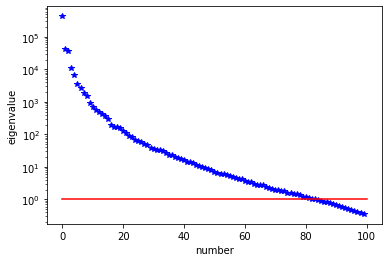

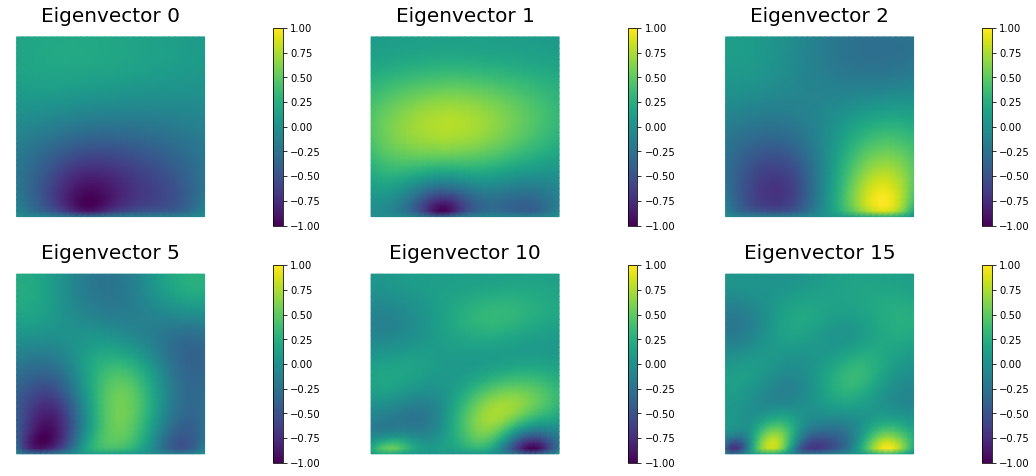

In [10]:
model.setPointForHessianEvaluations(x, gauss_newton_approx=False)
Hmisfit = ReducedHessian(model, solver.parameters["inner_rel_tolerance"], misfit_only=True)
k = 100
p = 20
print( "Single/Double Pass Algorithm. Requested eigenvectors: {0}; Oversampling {1}.".format(k,p) )

Omega = MultiVector(x[PARAMETER], k+p)
parRandom.normal(1., Omega)
lmbda, V = doublePassG(Hmisfit, prior.R, prior.Rsolver, Omega, k)

nu = GaussianLRPosterior(prior, lmbda, V)
nu.mean = x[PARAMETER]

plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')

nb.plot_eigenvectors(Vh[PARAMETER], V, mytitle="Eigenvector", which=[0,1,2,5,10,15])

### Prior and LA-posterior pointwise variance fields

LA-Posterior trace 1.299577e+00; Prior trace 4.772724e+00; Correction trace 3.473147e+00


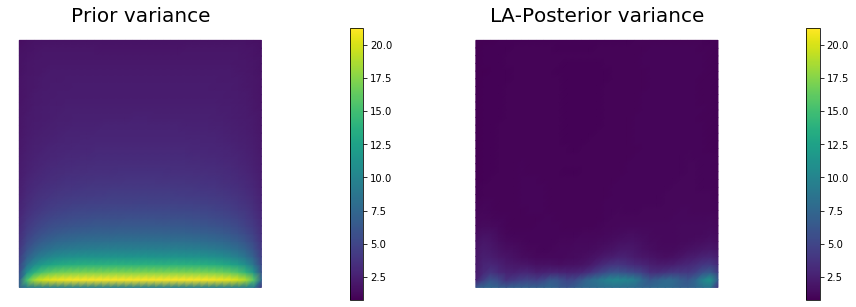

In [11]:
compute_trace = True
if compute_trace:
    post_tr, prior_tr, corr_tr = nu.trace(method="Randomized", r=200)
    print( "LA-Posterior trace {0:5e}; Prior trace {1:5e}; Correction trace {2:5e}".format(post_tr, prior_tr, corr_tr) )
post_pw_variance, pr_pw_variance, corr_pw_variance = nu.pointwise_variance(method="Exact")

objs = [dl.Function(Vh[PARAMETER], pr_pw_variance),
        dl.Function(Vh[PARAMETER], post_pw_variance)]
mytitles = ["Prior variance", "LA-Posterior variance"]
nb.multi1_plot(objs, mytitles, logscale=False)
plt.show()

### Generate samples from Prior and LA-Posterior

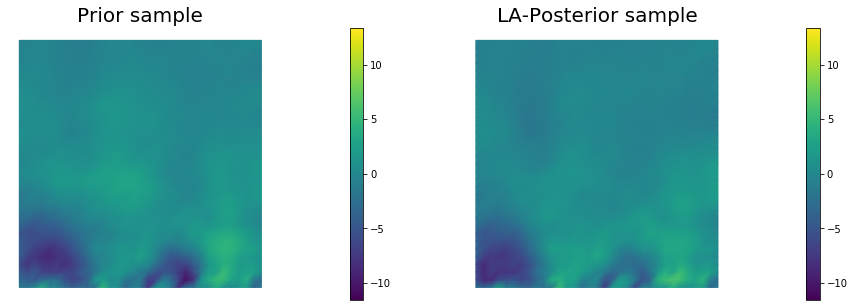

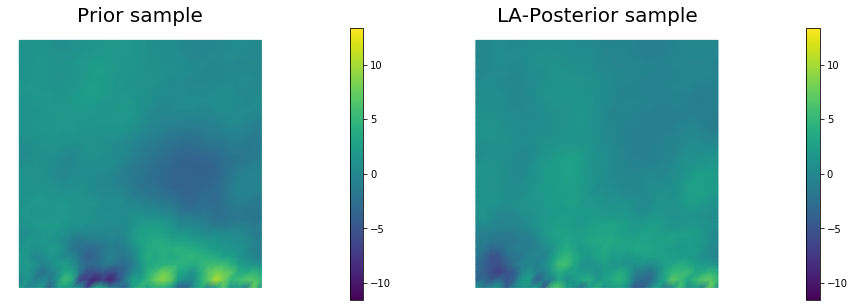

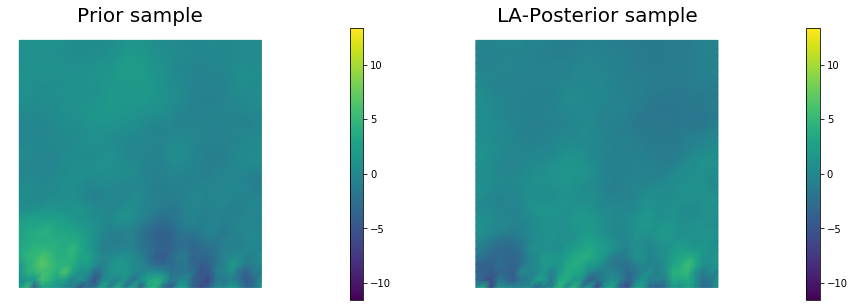

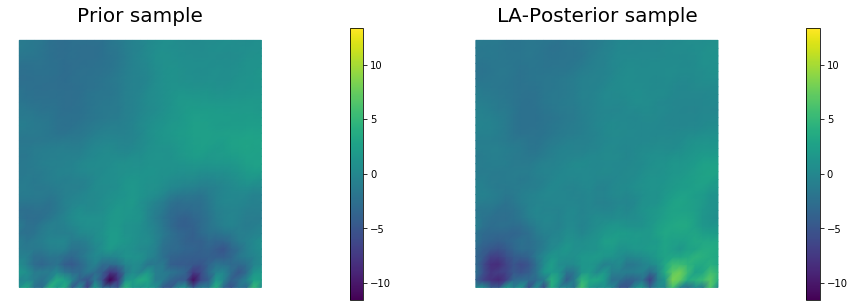

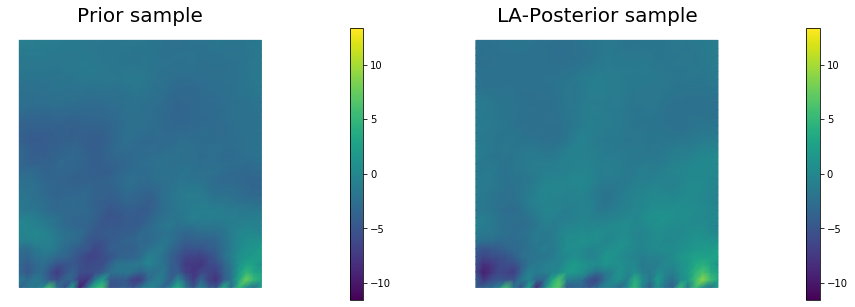

In [12]:
nsamples = 5
noise = dl.Vector()
nu.init_vector(noise,"noise")
s_prior = dl.Function(Vh[PARAMETER], name="sample_prior")
s_post = dl.Function(Vh[PARAMETER], name="sample_post")

pr_max   =  2.5*math.sqrt( pr_pw_variance.max() ) + prior.mean.max()
pr_min   = -2.5*math.sqrt( pr_pw_variance.max() ) + prior.mean.min()
ps_max   =  2.5*math.sqrt( post_pw_variance.max() ) + nu.mean.max()
ps_min   = -2.5*math.sqrt( post_pw_variance.max() ) + nu.mean.min()

vmax = max(pr_max, ps_max)
vmin = max(pr_min, ps_min)

for i in range(nsamples):
    parRandom.normal(1., noise)
    nu.sample(noise, s_prior.vector(), s_post.vector())
    plt.figure(figsize=(15,5))
    nb.plot(s_prior, subplot_loc=121,mytitle="Prior sample", vmin=vmin, vmax=vmax)
    nb.plot(s_post, subplot_loc=122,mytitle="LA-Posterior sample", vmin=vmin, vmax=vmax)
    plt.show()

### Define a quantify of interest

In [16]:
class FluxQOI(object):
    def __init__(self, Vh, dsGamma):
        self.Vh = Vh
        self.dsGamma = dsGamma
        self.n = dl.Constant((0.,1.))#dl.FacetNormal(Vh[STATE].mesh())
        
        self.u = None
        self.m = None
        self.L = {}
        
    def form(self, x):
        return dl.exp(x[PARAMETER])*dl.dot( dl.grad(x[STATE]), self.n)*self.dsGamma
    
    def eval(self, x):
        u = vector2Function(x[STATE], self.Vh[STATE])
        m = vector2Function(x[PARAMETER], self.Vh[PARAMETER])
        return np.log( dl.assemble(self.form([u,m])) )

class GammaBottom(dl.SubDomain):
    def inside(self, x, on_boundary):
        return ( abs(x[1]) < dl.DOLFIN_EPS )

# GC = GammaBottom()
# marker = dl.FacetFunction("size_t", mesh)
# marker.set_all(0)
# GC.mark(marker, 1)
dss = dl.Measure("ds", subdomain_data=marker)
qoi = FluxQOI(Vh,dss(1))

NameError: name 'marker' is not defined

In [14]:
def run_chain(kernel):
    noise = dl.Vector()
    nu.init_vector(noise, "noise")
    parRandom.normal(1., noise)
    pr_s = model.generate_vector(PARAMETER)
    post_s = model.generate_vector(PARAMETER)
    # Use a sample from LA-posterior as starting point for the chain
    nu.sample(noise, pr_s, post_s, add_mean=True)

    chain = MCMC(kernel)
    chain.parameters["burn_in"] = 1000
    chain.parameters["number_of_samples"] = 10000
    chain.parameters["print_progress"] = 10            
    tracer = QoiTracer(chain.parameters["number_of_samples"])

    n_accept = chain.run(post_s, qoi, tracer)

    print( "Number accepted = {0}".format(n_accept) )
    print( "E[q] = {0}".format(chain.sum_q/float(chain.parameters["number_of_samples"])) )
    
    q = tracer.data
    max_lag = 300
    integrated_corr_time, lags, acorrs = integratedAutocorrelationTime(q, max_lag)
    print ("Integrated autocorrelation time", integrated_corr_time)

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(q, '*b')
    plt.title("Trace plot")

    plt.subplot(132)
    plt.hist(q, normed=True)
    plt.title("Histogram")

    plt.subplot(133)
    plt.plot(lags, acorrs, '-b') 
    plt.title("Autocorrelation")
    plt.ylim([0., 1.])
    
    plt.show()
    

    return tracer

In [15]:
print("Sampling using pCN proposal")
kernel_pCN = pCNKernel(model)
kernel_pCN.parameters["s"] = 0.01
tracer = run_chain(kernel_pCN)

Sampling using pCN proposal


NameError: name 'qoi' is not defined